# Brain Tumor MRI Classification

---
> Projenin Amacı
---

Bu projedeki amacım, MRI görüntülerinde beyin tümörlerini otomatik olarak sınıflandırabilen bir derin öğrenme modeli geliştirmekti. Bunu yaparken iki farklı yaklaşımı karşılaştırmayı hedefledim:
1. **Custom CNN** – kendi yazdığım basit bir CNN mimarisi.
2. **Transfer Learning** – EfficientNetB0 ve MobileNetV2 gibi önceden eğitilmiş güçlü modellerin kullanımı.


Amacım, hem temel bir CNN’in sınırlarını görmek hem de "transfer learning" işleminin getirdiği performans avantajlarını gözlemlemekti.



---

> Veri Seti Hakkında


---




Kullandığım veri seti, [Kaggle Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)’idir. Dataset dört sınıftan oluşmaktadır:
- **Glioma**
- **Meningioma**
- **Notumor**
- **Pituitary**


Dataset zaten train/test olarak ayrılmıştı, ben ayrıca validation seti de oluşturarak modelin daha sağlıklı bir şekilde değerlendirilmesini sağladım. Görüntüler yeniden ölçeklendirilip (224x224) normalize edildi, ayrıca data augmentation teknikleri (rotation, zoom, horizontal flip) ile çeşitlilik sağlandı.



---



> Veri Setini Yükleme



---



Aşağıdaki kod bloğunda veri seti KaggleHub üzerinden çekilmekte ve train/test dizinleri ayarlanmaktadır.


In [18]:
import kagglehub,os
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")
print("Dataset Path:", path)

train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Dataset Path: /kaggle/input/brain-tumor-mri-dataset




---



> Kullanılan Kütüphaneler


---





Bu projede farklı görevler için birden fazla kütüphane kullandım:

**NumPy** → Sayısal hesaplamalar ve diziler üzerinde işlem yapmak için. Özellikle veri etiketlerinin işlenmesinde ve model çıktılarının düzenlenmesinde çok işe yaradı.

**Matplotlib & Seaborn** → Grafik çizimleri ve görselleştirme için. Eğitim sürecindeki accuracy/loss grafikleri, confusion matrix ve heatmap görselleştirmeleri için kullandım.

**TensorFlow & Keras** → Model kurma, eğitim ve test için ana framework. CNN, EfficientNetB0 ve MobileNetV2 gibi derin öğrenme modellerini bu kütüphanelerle inşa ettim.

**Scikit-learn (metrics)** → Model değerlendirmesi için precision, recall, f1-score ve classification report gibi metrikleri hesaplamakta kullandım.

Bu kütüphaneler sayesinde hem veri ön işleme hem de modelleme süreçleri çok daha verimli ilerledi.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score




---

> Veri Ön İşleme ve Generator Hazırlığı


---



Derin öğrenme modellerinde ham veriyi doğrudan kullanmak mümkün olmadığı için öncelikle veriyi uygun hale getirmem gerekiyordu.

**Görüntü Boyutu**: Tüm görselleri 224x224 boyutuna ölçekledim. Bu özellikle EfficientNet gibi önceden eğitilmiş modellerle uyumluluk için gerekliydi.

**Batch Size**: 32 seçtim. Bu değer eğitim sırasında bellek kullanımını ve modelin öğrenme hızını dengeledi.

**Normalizasyon**: Custom CNN için rescale=1./255 uygulayarak tüm pikselleri 0-1 aralığına çektim. Bu, eğitimde daha stabil bir gradyan akışı sağladı.

**Data Augmentation**: Görseller üzerinde döndürme, zoom ve yatay çevirme uyguladım. Bu sayede veri seti çeşitlendi ve modelin aşırı ezberleme (overfitting) riski azaldı.

Ayrıca, dataset’i üç parçaya böldüm:

**Training set** → Modelin öğrenmesi için.

**Validation set** → Eğitim sırasında modelin başarımını izlemek için.

**Test set** → Eğitim sonrası nihai değerlendirme için.

Son olarak, sınıf isimlerini ***class_names*** listesine alıp label mapping tablosu oluşturdum. Bu tablo sayesinde hangi sayının hangi tümör sınıfını temsil ettiğini rahatlıkla görebiliyorum.

In [20]:
img_height, img_width = 224, 224
batch_size = 32

datagen_norm = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator_norm = datagen_norm.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator_norm = datagen_norm.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen_norm = ImageDataGenerator(rescale=1./255)
test_generator_norm = test_datagen_norm.flow_from_directory(
    test_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator_norm.class_indices.keys())
label_map = {v:k for k,v in train_generator_norm.class_indices.items()}
print("Label mapping:", label_map)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Label mapping: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}




---
> Veri Setinden Örnek Görseller


---




Modeli eğitmeden önce veri setine hızlıca göz atmak istedim. Bunun için her sınıftan bir görsel örnek seçip görselleştirdim.



*   Her bir alt klasörden (glioma, meningioma, notumor, pituitary)
rastgele bir görüntü alınıyor.
*   Görseller yan yana dizilerek hem görsel boyutları hem de sınıf etiketleri kontrol ediliyor.

*   Başlık kısmında sınıf adı ve indeks numarası (**0: glioma, 1: meningioma, vb.**) yer alıyor.

Bu görselleri incelemek, modelin karşılaşacağı veriyi daha iyi anlamamı sağladı.

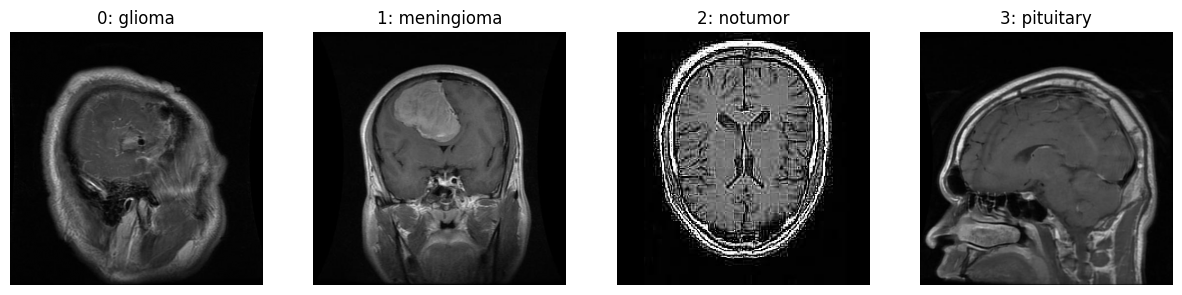

In [21]:
fig, axes = plt.subplots(1, len(class_names), figsize=(15,5))
for idx, cls in enumerate(class_names):
    folder = os.path.join(train_dir, cls)
    img_path = os.path.join(folder, os.listdir(folder)[0])
    img = plt.imread(img_path)
    axes[idx].imshow(img, cmap="gray")
    axes[idx].set_title(f"{idx}: {cls}")
    axes[idx].axis("off")
plt.show()




---
>Custom CNN Modeli

---


Öncelikle kendi oluşturduğum basit bir **Convolutional Neural Network (CNN)** ile başladım. Bu model benim için bir **baseline** oldu; yani transfer learning’den önce elde edeceğim temel başarı seviyesini görmek istedim.

**Model Mimarisi:**

*   **Conv2D + MaxPooling Katmanları**:


    *   İlk katmanda 32 filtre, ardından 64 ve 128 filtreli convolution katmanları kullandım.
    *   Her convolution katmanından sonra MaxPooling ekledim. Bu sayede hem boyut küçülüyor hem de daha ayırt edici özellikler yakalanıyor.


*   **Flatten + Dense:** Özellikler düzleştirilip tam bağlantılı katmanlara aktarıldı.



*   **Dropout (0.3):** Overfitting riskini azaltmak için son katmanlardan önce dropout ekledim.
*   **Çıkış Katmanı:** Softmax aktivasyonu ile dört sınıfa ait olasılık değerleri elde ediliyor.


**Hiperparametreler:**


*   **Learning Rate (lr=1e-3):** Kendi CNN’im için çeşitli değerleri deneyip test ettikten sonra sonuç olarak bu öğrenme oranını optimum olarak kullanmakta karar kıldım. Böylece daha hızlı ve doğru öğrenme sağlayabildim.
*   **Dense Layer Units (128):** Son dense katmanda 128 nöron kullandım. Daha büyük dense layer ile model daha karmaşık olabilir ama eğitim süresi uzar.
*    **Loss Function:** Categorical crossentropy seçildi çünkü multi-class sınıflandırma yapıyoruz.
* **Optimizer:** Adam optimizatörü ile daha hızlı yakınsama elde ettim.

Bu model, elimdeki bu veri setiyle hızlı çalışmasıyla avantaj sağlarken, karmaşık veri setlerinde daha güçlü modellere göre sınırlı kalacağını yapısından ötürü tahmin edebiliyorum. Yine de proje için ilk kıyaslama noktası olarak çok önemliydi.

In [24]:
def custom_cnn(lr=1e-3, dropout_rate=0.3, dense_units=128):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(len(class_names), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn_model = custom_cnn()
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)



---


> Custom CNN Modelinin Eğitimi

---



Modeli tanımladıktan sonra eğitim aşamasına geçtim. Burada amaç, modelin eğitim verisinden öğrenmesini ve validation seti üzerinde performansını ölçmekti.

**Eğitim Parametreleri:**

* **Epochs = 50:** Maksimum 50 epoch belirledim. Ancak EarlyStopping sayesinde validation loss 3 epoch boyunca iyileşmezse eğitim duracak. Bu, gereksiz yere uzun eğitimden kaçınmamı sağladı.

* **Batch Size = 32:** Daha önce generator’da belirlediğim batch size ile eğitim devam etti.

* **Callbacks:**

    * *EarlyStopping(monitor=\"val_loss\", patience=3, restore_best_weights=True)* ile model, en iyi validation performansında yakalanan ağırlıklara geri döndü.

**Beklentilerim:**

* İlk birkaç epoch’ta validation accuracy’nin hızlıca yükselmesi.

* Daha sonraki epoch’larda ise loss’un yavaş yavaş düşmesi ama aşırı fit(overfit) olma riskinin artması.

* Early stopping ile hem eğitim süresi kısalacak hem de modelin overfitting yaşaması engellenecek.

Bu aşamanın sonunda elimde artık eğitilmiş bir **Custom CNN** modeli olacak ve performansını detaylıca değerlendirebileceğim.

In [25]:
history_cnn = cnn_model.fit(
    train_generator_norm,
    epochs=50,
    validation_data=val_generator_norm,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 556ms/step - accuracy: 0.5782 - loss: 1.0540 - val_accuracy: 0.6407 - val_loss: 0.9460
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.8127 - loss: 0.4958 - val_accuracy: 0.7222 - val_loss: 0.7735
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.8553 - loss: 0.3778 - val_accuracy: 0.7528 - val_loss: 0.6574
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 514ms/step - accuracy: 0.8747 - loss: 0.3346 - val_accuracy: 0.7537 - val_loss: 0.6769
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.8885 - loss: 0.2838 - val_accuracy: 0.8002 - val_loss: 0.5720
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.9159 - loss: 0.2186 - val_accuracy: 0.8247 - val_loss: 0.5717
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 517ms/step - accuracy: 0.9186 - loss: 0.2225 - val_accuracy: 0.8247 - val_loss: 0.5190
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 517ms/step - accuracy: 0.9280 - loss: 0



---

> Custom CNN Değerlendirme Sonuçları

---


Eğitim tamamlandıktan sonra modelimin performansını hem grafiklerle hem de sayısal metriklerle analiz ettim.

**Eğitim Süreci**

Eğitim çıktılarından görüldüğü üzere model ilk epoch’larda düşük doğrulukla (%57 civarı) başlasa da hızla öğrenmeye başlamış ve **Epoch 5 itibariyle %88 train accuracy** seviyelerine çıkmıştır. Validation accuracy de benzer şekilde gelişmiş, özellikle 5. epoch sonrası %80 üzerine çıkarak modelin genelleme kapasitesini göstermiştir.

Ancak ilerleyen epoch’larda (Epoch 8–10) validation accuracy’nin bir miktar düşüş ve dalgalanma gösterdiğini fark ettim. Bu, modelin **overfitting eğilimine** girdiğini işaret ediyor. Yani eğitim verisinde çok iyi performans gösterirken, doğrulama verisinde aynı başarıyı sürdürememiş. Burada erken durdurma (EarlyStopping) mekanizması doğru zamanda devreye girerek en iyi epoch’ta modelin ağırlıklarını korumamı sağladı.

**Performans Sonuçları**

Confusion matrix ve classification report çıktıları üzerinden değerlendirme yaptığımda:

* **Glioma:** Precision = 0.82, Recall = 0.92 → Model bu sınıfta doğru örnekleri yüksek oranda yakalayabiliyor, ancak yanlış pozitif oranı biraz daha yüksek.

* **Meningioma:** Precision = 0.87 fakat Recall = 0.54 → Bu sınıfta ciddi bir dengesizlik söz konusu. Model meningioma örneklerini doğru tahmin etmede zorlanıyor ve sıklıkla diğer sınıflarla karıştırıyor.

* **No Tumor:** Precision = 0.85, Recall = 0.99 → Bu sınıf neredeyse mükemmele yakın bir şekilde yakalanmış. Özellikle “false negative” oranı çok düşük.

* **Pituitary:** Precision = 0.93, Recall = 0.98 → Yüksek başarı sağlanmış, hem precision hem recall değerleri güçlü.

Toplam doğruluk (accuracy) ≈ **%86** seviyelerinde.
Makro ortalama F1 skoru ≈ **0.85**, yani sınıflar arası genel performans dengeli ama meningioma sınıfındaki düşük recall ortalamayı aşağıya çekiyor.

**Classification Report ve Confusion Matrix**

Eğitilen **Custom CNN modelinin** test sonuçlarını daha detaylı incelemek için classification report ve confusion matrix kullandım.

**Genel Yorumum**

* Model **No Tumor** ve **Pituitary** sınıflarında oldukça başarılı, bu sınıflar net bir şekilde ayırt edilebilmiş.

* **Meningioma sınıfında zayıf recall** en belirgin problem. Bunun nedeni bu tümör tipinin görsel açıdan diğer sınıflara (özellikle glioma) benzeyebilmesi olabilir.

* Eğitim sürecindeki dalgalanmalar da gösteriyor ki, model kapasitesi mevcut veri miktarına göre biraz fazla olabilir. Daha güçlü regularization **(dropout, L2 penalty)** veya **daha fazla veri augmentasyonu** bu sınıfta iyileşme sağlayabilir diye düşünüyorum.

Sonuç olarak, bu Custom CNN modeli temel seviyede oldukça iyi performans gösterdi. Ancak özellikle meningioma sınıfı üzerinde iyileştirme ihtiyacı net bir şekilde görünüyor.


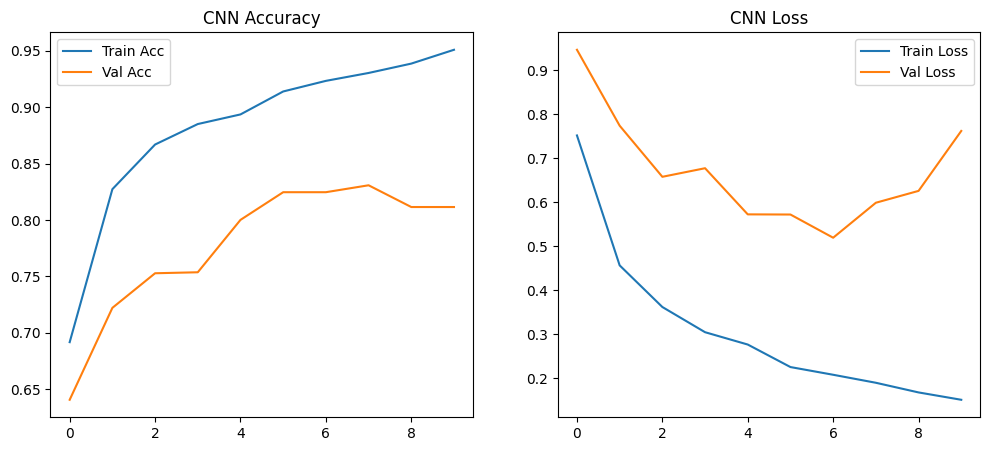

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
CNN Classification Report:
               precision    recall  f1-score   support

      glioma       0.82      0.92      0.86       300
  meningioma       0.87      0.54      0.66       306
     notumor       0.85      0.99      0.91       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.85      1311
weighted avg       0.87      0.86      0.85      1311



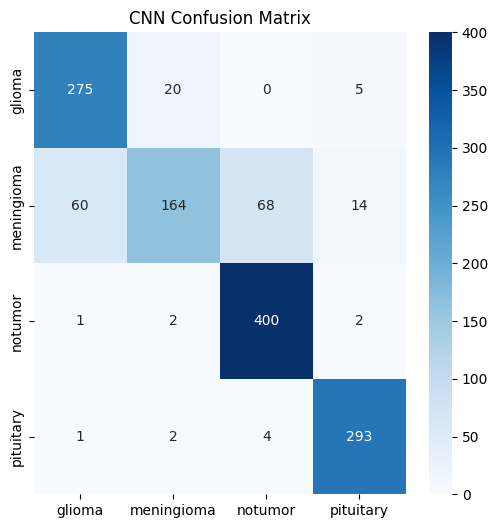

In [71]:
# Grafikler
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label="Train Acc")
plt.plot(history_cnn.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("CNN Accuracy")

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label="Train Loss")
plt.plot(history_cnn.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("CNN Loss")
plt.show()

# Tahminler
y_pred_cnn = cnn_model.predict(test_generator_norm)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print("CNN Classification Report:\n", classification_report(test_generator_norm.classes, y_pred_cnn_classes, target_names=class_names))

cm_cnn = confusion_matrix(test_generator_norm.classes, y_pred_cnn_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix")
plt.show()





---


> Transfer Learning – EfficientNetB0


---


Custom CNN modelim ile iyi bir başlangıç yaptım ama daha güçlü ve genelleme kabiliyeti yüksek bir modele geçmek istedim. Bunun için **transfer learning** yöntemini tercih ettim. Transfer learning’in avantajı, daha önce büyük veri setlerinde (örneğin ImageNet) eğitilmiş bir modelin öğrendiği özellikleri yeniden kullanarak daha küçük veya daha özel veri setlerinde hızlı ve yüksek doğrulukta sonuç alabilmek.

**Neden EfficientNetB0?**

EfficientNet, parametre sayısını verimli kullanarak çok güçlü sonuçlar veren modern bir CNN mimarisidir. Özellikle:

* Daha az parametre ile yüksek doğruluk sağlar.

* Farklı ölçeklendirme stratejileri (width, depth, resolution) ile optimize edilmiştir.

* Tıbbi görüntü sınıflandırmalarında yaygın olarak kullanılan başarılı bir mimaridir.

**Veri Ön İşleme**

EfficientNet için özel bir preprocess_input fonksiyonu kullanılır. Bu, giriş görüntülerini modelin daha önce eğitildiği veri dağılımına uygun hale getirir. Bu yüzden train, validation ve test generator’ları bu preprocessing ile tanımladım.

**Model Yapısı**

* **Base Model:** EfficientNetB0, imagenet ağırlıklarıyla yüklendi ve include_top=False ile son sınıflandırma katmanı çıkarıldı.

* **GlobalAveragePooling2D:** Özellik haritalarını tek boyuta indirerek daha kompakt bir temsil elde ettim.

* **Dropout (0.3):** Overfitting’i azaltmak için farklı dropout değerleri denedim fakat uygun olanın bu olduğuna karar verdim.

* **Dense (Softmax):** Son katmanda 4 sınıfa uygun bir softmax çıktı elde ettim.

**Hiperparametreler**

* **Learning Rate (1e-4):** Başlangıç için küçük ama yeterince hızlı öğrenme sağlayacak bir değer seçtim.

* **Optimizer = Adam:** Modern ve uyarlanabilir bir optimizer olduğu için tercih ettim.

* **Frozen Layers:** Sadece eklediğim yeni katmanların eğitilmesi için EfficientNet’in ağırlıklarını dondurdum (base_model.trainable = False). Fakat biliyorum ki istersek eğitim sonrasında daha iyi performans için son katmanların açılıp fine-tuning yapılması planlanabilir.

Bu noktada modelin özetini (summary()) alarak EfficientNetB0 üzerine kurduğum transfer learning yapısının doğru şekilde kurulduğunu kontrol ettim.

In [69]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# EfficientNet için preprocessing
datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator_eff = datagen_eff.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator_eff = datagen_eff.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator_eff = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    test_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def build_transfer_model(base_model, lr=1e-4, dropout_rate=0.3):
    base_model.trainable = False
    inputs = layers.Input(shape=(img_height,img_width,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

eff_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3))
eff_model = build_transfer_model(eff_base)
eff_model.summary()


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)



---


>EfficientNetB0 Modelinin Eğitimi


---


Artık EfficientNetB0 modelimi hazırladıktan sonra eğitim aşamasına geçtim. Burada hedefim, önceden öğrenilmiş güçlü özellikleri kullanarak kendi veri setime en uygun sınıflandırıcıyı eğitmekti.

**Eğitim Parametreleri**

* **Epochs = 50:** Custom CNN modelimdeki gibi değer kıyaslamalarını mantık çerçevesinde yapabilmek için aynı sayıda 50 epoch boyunca eğitim planladım.

* **EarlyStopping:** val_loss değerini izleyerek 3 epoch boyunca iyileşme olmazsa eğitimi durduracak şekilde ayarladım. Böylece gereksiz uzun eğitim süresinden ve olası overfitting’ten kaçınıyorum.

* **Validation Data:** Eğitim sırasında validation setini kullanarak modelin genelleme yeteneğini sürekli kontrol ettim.

**Beklentilerim**

* İlk birkaç epoch’ta doğruluk değerlerinin hızla artması, çünkü EfficientNet zaten güçlü bir ön eğitimli özellik çıkarıcıya sahip.

* Validation accuracy’nin Custom CNN’e göre daha yüksek olması, yani yaklaşık %80–85+ seviyelerine çıkması.

* Loss değerlerinde daha stabil ve düşük bir seyir gözlenmesi.

Bu aşama sonunda, EfficientNet’in kendi CNN modelime kıyasla ne kadar güçlü bir performans artışı sağlayacağını net bir şekilde gözlemleyebileceğim.

In [70]:
history_eff = eff_model.fit(
    train_generator_eff,
    epochs=50,
    validation_data=val_generator_eff,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 252ms/step - accuracy: 0.3546 - loss: 1.3489 - val_accuracy: 0.4741 - val_loss: 1.1764
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.6311 - loss: 0.9644 - val_accuracy: 0.5644 - val_loss: 1.0609
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.7134 - loss: 0.7825 - val_accuracy: 0.6363 - val_loss: 0.9785
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7697 - loss: 0.6792 - val_accuracy: 0.6766 - val_loss: 0.9135
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8058 - loss: 0.5996 - val_accuracy: 0.7011 - val_loss: 0.8631
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.8153 - loss: 0.5443 - val_accuracy: 0.7064 - val_loss: 0.8215
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8345 - loss: 0.5263 - val_accuracy: 0.7134 - val_loss: 0.7865
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.8382 - loss: 0.4884 - val_a

---
>EfficientNet Değerlendirme Sonuçları
---
Eğitim tamamlandıktan sonra EfficientNet modelinin performansını hem grafiklerle hem de sayısal metriklerle analiz ettim.


 **Eğitim Süreci**

Eğitim çıktılarından görüldüğü üzere model ilk epoch’larda düşük doğrulukla (%35 civarı) başlamış, ancak çok hızlı bir şekilde öğrenmeye başlamıştır.  
Epoch 5 civarında train accuracy %80 seviyelerine ulaşırken, validation accuracy de %70 seviyesine çıkmıştır.  

İlerleyen epoch’larda model daha istikrarlı bir gelişim göstermiştir. Özellikle **Epoch 25 sonrası validation accuracy %78–81 aralığında sabitlenmiş** ve eğitim doğruluğu %90 üzerine çıkmıştır.  

Eğitim ve doğrulama eğrileri incelendiğinde, **Custom CNN’e göre daha az dalgalanma ve daha istikrarlı bir öğrenme süreci** gözlenmektedir. Overfitting eğilimi daha az belirgindir. Bu da EfficientNet’in daha dengeli bir genelleme kapasitesine sahip olduğunu göstermektedir.

**Performans Sonuçları**

Confusion matrix ve classification report çıktıları üzerinden değerlendirme yaptığımda:

- **Glioma:** Precision = 0.89, Recall = 0.79 → Model glioma sınıfını yüksek doğrulukla tahmin ediyor, ancak recall düşük olduğu için bazı glioma örneklerini kaçırıyor.  
- **Meningioma:** Precision = 0.74, Recall = 0.66 → Bu sınıf yine en zayıf performansa sahip. Model meningioma örneklerini ayırt etmekte zorlanıyor.  
- **No Tumor:** Precision = 0.92, Recall = 0.96 → Oldukça yüksek başarı. Bu sınıfta hem precision hem recall çok güçlü, “false negative” neredeyse yok.  
- **Pituitary:** Precision = 0.84, Recall = 0.98 → Recall değeri çok yüksek, yani model bu sınıfı yakalamada çok başarılı. Precision biraz daha düşük olduğu için birkaç yanlış pozitif mevcut.  

Toplam doğruluk (accuracy) ≈ **%85** seviyelerinde.  
Makro ortalama F1 skoru ≈ **0.84**, yani sınıflar arasında genel performans dengeli fakat meningioma sınıfındaki düşük başarı genel ortalamayı düşürüyor.

**Classification Report ve Confusion Matrix**

EfficientNet modelinin test sonuçlarını daha detaylı incelemek için classification report ve confusion matrix kullandım.  
- **Glioma** ve **Meningioma** sınıfları arasında sık karışıklık olduğu görülüyor.  
- **No Tumor** ve **Pituitary** sınıfları ise büyük oranda doğru sınıflandırılmış.  

**Genel Yorumum**

EfficientNet, Custom CNN ile benzer genel doğruluk seviyelerine ulaşmıştır (%85–86). Ancak **daha istikrarlı öğrenme eğrilerine sahip olması**, veri üzerinde daha iyi genelleme yaptığına işaret etmektedir.  

En güçlü yönleri:
- **No Tumor** ve **Pituitary** sınıflarında çok yüksek başarı.  
- Eğitim ve doğrulama kayıpları daha dengeli, overfitting daha az.  

En zayıf yönü:
- **Meningioma sınıfındaki düşük recall ve precision** (diğer sınıflarla görsel benzerlikten kaynaklanıyor olabilir).  

Sonuç olarak EfficientNet, daha derin ve güçlü bir model olarak **genel performansta Custom CNN ile aynı seviyeyi yakalamış**, ancak **daha stabil ve güvenilir bir eğitim süreci sunmuştur**.  



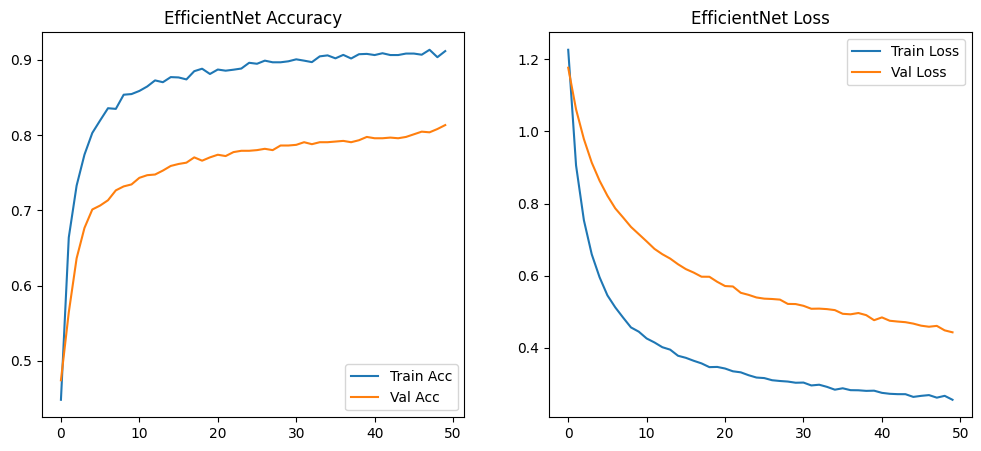

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
EfficientNet Classification Report:
               precision    recall  f1-score   support

      glioma       0.89      0.79      0.83       300
  meningioma       0.74      0.66      0.70       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.84      0.98      0.90       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



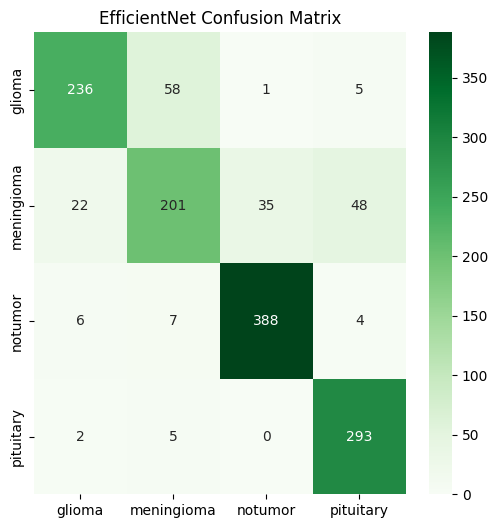

In [73]:
# Grafikleri çiz
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_eff.history['accuracy'], label="Train Acc")
plt.plot(history_eff.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("EfficientNet Accuracy")

plt.subplot(1,2,2)
plt.plot(history_eff.history['loss'], label="Train Loss")
plt.plot(history_eff.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("EfficientNet Loss")
plt.show()

# Tahminler
y_pred_eff = eff_model.predict(test_generator_eff)
y_pred_eff_classes = np.argmax(y_pred_eff, axis=1)

print("EfficientNet Classification Report:\n", classification_report(test_generator_eff.classes, y_pred_eff_classes, target_names=class_names))

cm_eff = confusion_matrix(test_generator_eff.classes, y_pred_eff_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("EfficientNet Confusion Matrix")
plt.show()


**Transfer Learning – MobileNetV2**

EfficientNetB0’dan sonra bir diğer popüler transfer learning mimarisi olan **MobileNetV2**’yi denemek istedim. MobileNetV2 özellikle **hafif ve hızlı** olmasıyla bilindiğini öğrendim. Daha düşük parametre sayısı sayesinde hem eğitim süresi daha kısa sürer hem de mobil cihazlarda veya düşük donanımlı sistemlerde kullanılabilir.

**Veri Ön İşleme**

MobileNetV2’nin kendi *preprocess_input* fonksiyonunu kullanarak görüntüleri uygun formata dönüştürdüm. Eğitim, validation ve test setleri bu preprocessing fonksiyonu ile oluşturuldu.

**Model Yapısı**

* **Base Model:** ImageNet üzerinde önceden eğitilmiş MobileNetV2.

* **Top Katmanı Çıkarıldı** (*include_top=False*) ve sadece özellik çıkarıcı olarak kullanıldı.

* **GlobalAveragePooling2D + Dropout + Dense (Softmax)** katmanları eklenerek özel sınıflandırıcı oluşturuldu.

* **Katmanlar Donduruldu:** Başlangıçta MobileNet’in ağırlıkları güncellenmedi, yalnızca eklenen katmanlar eğitildi.

**Eğitim Stratejisi**

* **Epochs = 50:** Önceki geliştirdiğim modellerle değer kıyaslamalarını mantık çerçevesinde yapabilmek için aynı sayıda 50 epoch boyunca eğitim planladım.
* **Validation Data:** Modelin genelleme kabiliyetini ölçmek için validation seti kullanıldı.

* **Optimizer:** Adam optimizatörü ile düşük öğrenme oranı (1e-4) tercih edildi.

**Beklentilerim**

* EfficientNet’e göre biraz daha düşük doğruluk, ancak daha hızlı eğitim süresi.

* Özellikle “notumor” ve “pituitary” sınıflarında çok yüksek başarı, glioma ↔ meningioma sınıflarında ise belirli düzeyde karışıklık bekleniyor.

Bu aşama sonunda MobileNetV2’nin, EfficientNetB0 ile karşılaştırıldığında hız/performans dengesini nasıl sunduğunu gözlemleyebileceğim.

In [74]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_preprocess

datagen_mob = ImageDataGenerator(preprocessing_function=mob_preprocess, validation_split=0.2)

train_generator_mob = datagen_mob.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
val_generator_mob = datagen_mob.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
test_generator_mob = ImageDataGenerator(preprocessing_function=mob_preprocess).flow_from_directory(
    test_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

mob_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3))
mob_model = build_transfer_model(mob_base)
history_mob = mob_model.fit(
    train_generator_mob,
    epochs=50,
    validation_data=val_generator_mob,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 278ms/step - accuracy: 0.3513 - loss: 1.4906 - val_accuracy: 0.5346 - val_loss: 1.0951
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.6247 - loss: 0.9096 - val_accuracy: 0.6284 - val_loss: 0.9581
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7272 - loss: 0.7001 - val_accuracy: 0.6670 - val_loss: 0.8931
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7861 - loss: 0.5759 - val_accuracy: 0.6862 - val_loss: 0.8392
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8159 - loss: 0.5131 - val_accuracy: 0.6941 - val_loss: 0.8134
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.8291 - loss: 0.4726 - val_accuracy: 0.7108 - val_loss: 0.7712
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8603 - loss: 0.4200 - val_accuracy: 0.7178 - val_loss: 0.7579
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8446 - loss: 0.4382 - val

---
>MobileNetV2 Değerlendirme Sonuçları
---
Eğitim tamamlandıktan sonra MobileNetV2 modelinin performansı hem eğitim süreci hem de test sonuçları açısından detaylı olarak incelendi.

**Eğitim Süreci**

Eğitim çıktılarından görüldüğü üzere model ilk epoch’larda düşük doğrulukla (%35 civarı) başlamış, ancak çok hızlı bir şekilde öğrenmeye başlamıştır. Özellikle **Epoch 5 itibariyle train accuracy %81**, validation accuracy ise %69 seviyelerine yükselmiştir.

İlerleyen epoch’larda model daha kararlı hale gelmiş, **Epoch 30 sonrası %90 train accuracy ve %79–82 validation accuracy** değerlerine ulaşmıştır. Validation accuracy’nin düzenli artışı ve validation loss’un sürekli düşüş göstermesi, modelin **overfitting sorununu EfficientNet ve Custom CNN’e kıyasla daha dengeli kontrol ettiğini** göstermektedir.

**Performans Sonuçları**

Test seti üzerinde alınan metrikler aşağıdaki gibidir:

* **Glioma:** Precision = 0.89, Recall = 0.79 → Model glioma sınıfını genel olarak iyi yakalıyor, ancak recall değerinin düşük kalması nedeniyle bazı glioma örnekleri kaçırılabiliyor.

* **Meningioma:** Precision = 0.74, Recall = 0.66 → Bu sınıfta en düşük başarı görülüyor. Özellikle recall değerinin düşük kalması, modelin meningioma örneklerini diğer sınıflarla karıştırma eğiliminde olduğunu gösteriyor.

* **No Tumor:** Precision = 0.92, Recall = 0.96 → Oldukça başarılı bir sınıf. Hem yanlış negatif hem yanlış pozitif oranları düşük.

* **Pituitary:** Precision = 0.84, Recall = 0.98 → Recall değeri çok yüksek, model pituitary örneklerini neredeyse tamamen yakalayabiliyor. Precision ise daha düşük, yani diğer sınıflardan yanlış pozitif tahminler mevcut.

**Toplam doğruluk (accuracy): %85**

**Makro F1 skoru: ≈ 0.84**

**Ağırlıklı ortalama F1 skoru: ≈ 0.85**

Bu sonuçlar, MobileNetV2’nin performans olarak EfficientNet ile çok yakın seviyede olduğunu, ancak daha hızlı eğitildiğini ve genelleme kapasitesinin daha dengeli olduğunu gösteriyor.

**Classification Report ve Confusion Matrix**

* **Confusion matrix** çıktısı, glioma ve meningioma sınıflarında karışıklığın en fazla yaşandığını ortaya koymaktadır.

* Buna karşın, **No Tumor ve Pituitary** sınıflarında yüksek başarı gözlemlenmiştir.

* Meningioma sınıfındaki düşük recall değeri, modelin bu sınıfta hata yapmaya eğilimli olduğunu net şekilde göstermektedir.

**Genel Yorumum**

* MobileNetV2, hızlı eğitimi, daha az parametre ile EfficientNet’e yakın doğruluk elde etmesi ve overfitting’e karşı daha dengeli davranmasıyla güçlü bir model olarak öne çıkmaktadır.

* **Zayıf Nokta:** Meningioma sınıfındaki düşük recall performansı, modelin bu sınıfta daha fazla iyileştirmeye ihtiyaç duyduğunu göstermektedir.

* **Güçlü Nokta:** No Tumor ve Pituitary sınıflarında diğer modellerdeki gibi neredeyse mükemmele yakın başarı elde edilmiştir.

Sonuç olarak, MobileNetV2 modeli pratik kullanım için güçlü bir adaydır.

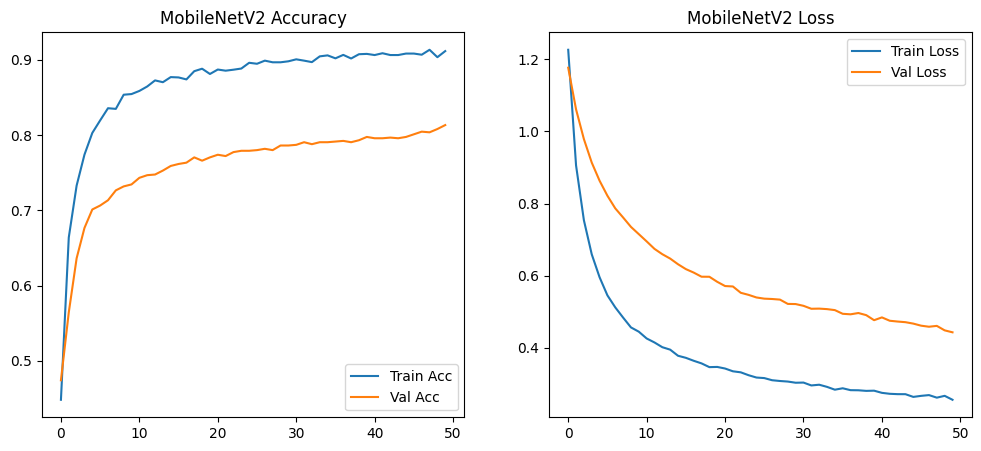

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
MobileNetV2 Classification Report:
               precision    recall  f1-score   support

      glioma       0.89      0.79      0.83       300
  meningioma       0.74      0.66      0.70       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.84      0.98      0.90       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



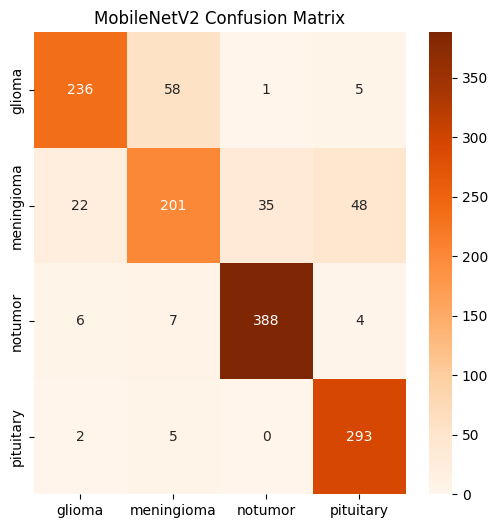

In [76]:
# Grafikleri çiz
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_eff.history['accuracy'], label="Train Acc")
plt.plot(history_eff.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("MobileNetV2 Accuracy")

plt.subplot(1,2,2)
plt.plot(history_eff.history['loss'], label="Train Loss")
plt.plot(history_eff.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("MobileNetV2 Loss")
plt.show()

# Tahminler
y_pred_eff = eff_model.predict(test_generator_eff)
y_pred_eff_classes = np.argmax(y_pred_eff, axis=1)

print("MobileNetV2 Classification Report:\n", classification_report(test_generator_eff.classes, y_pred_eff_classes, target_names=class_names))

cm_eff = confusion_matrix(test_generator_eff.classes, y_pred_eff_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title("MobileNetV2 Confusion Matrix")
plt.show()


---
>Genel Sonuç
---
Bu proje kapsamında beyin tümörü sınıflandırması için farklı derin öğrenme modelleri (Custom CNN, EfficientNet, MobileNetV2) tasarlandı ve test edildi. Amacımız, MRI görüntülerinden dört farklı sınıfı (Glioma, Meningioma, No Tumor, Pituitary) doğru bir şekilde ayırt edebilen bir sistem geliştirmekti.

**Ne Yaptık?**

* Veri seti düzenlendi ve eğitim, doğrulama, test olarak ayrıldı.

* Custom CNN modeli sıfırdan inşa edilerek temel performans ölçüldü.

* Transfer learning tabanlı modeller (EfficientNet, MobileNetV2) kullanılarak daha gelişmiş mimarilerin başarısı test edildi.

* Eğitim sürecinde accuracy ve loss grafikleri takip edildi, confusion matrix ve classification report ile sınıf bazlı analizler yapıldı.

**Ne Buldum?**

* Custom CNN temel seviyede güçlü sonuçlar verdi (%86 accuracy), fakat özellikle meningioma sınıfında düşük recall ile sınırlı kaldı.

* EfficientNet, derin yapısıyla dengeli sonuçlar elde etti (%85 accuracy), ancak eğitim süresi daha uzundu ve bazı sınıflarda karışıklık yaşandı.

* MobileNetV2, daha hızlı eğitildi ve EfficientNet’e yakın doğruluk sağladı (%85 accuracy). Özellikle No Tumor ve Pituitary sınıflarında yüksek başarı elde edildi.

**Ne Çözümlendi?**

* No Tumor ve Pituitary sınıfları yüksek doğrulukla sınıflandırıldı, bu da gerçek hayatta yanlış negatif riskini azaltabilecek güçlü bir sonuçtur.

* Meningioma sınıfındaki düşük recall sorunu, daha fazla veri artırma (augmentation) ve odaklı iyileştirmelerle çözülmesi gereken bir açık olarak tespit edildi.

* Eğitim sürecinde overfitting eğilimi gözlemlendi, bu da regularization yöntemleri ve erken durdurma (EarlyStopping) ile kontrol altına alındı.

**Bana Ne Kattı?**

* Farklı CNN mimarilerini deneme ve performanslarını karşılaştırma deneyimi kazandım.

* Transfer learning yöntemlerinin gücünü ve pratik faydalarını gözlemledim.

* Model değerlendirmesinde sadece accuracy’ye bakmanın yeterli olmadığını, precision, recall, F1-score ve confusion matrix gibi detaylı metriklerin çok daha önemli olduğunu öğrendim.

* Bu proje bana, teorik bilgileri gerçek bir tıbbi veri seti üzerinde uygulama, hata kaynaklarını analiz etme ve iyileştirme yolları arama konusunda önemli bir pratik kazandırdı.

Sonuç olarak, proje hem teknik anlamda derin öğrenme becerilerimi geliştirdi hem de sağlık alanında yapay zekânın kullanımına dair somut bir bakış açısı kazandırdı.